## Dataset: Swedish texts published during 2021 about *COVID-19*
### Topic modeling using BERTopic

We'll use the command line tool [cURL](https://en.wikipedia.org/wiki/CURL) to download a file from a URL. We also download a file `extended_stopwords.txt` containing a list of Swedish, and some English [stop words](https://en.wikipedia.org/wiki/Stop_word). These contain words like conjunctions, pronouns or prepositions, which are typically non-informative, and which we'd like to filter out. For BERTopic *stop word removal is performed as an optional post-processing* step, done ***after*** the model has been fitted. The choice of stop words -- in other words -- does not in any way affect the topics detected when using BERTopic.

In [ ]:
!curl -L https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/refs/heads/main/textual-resources/sv_CovidCorpus2.csv --output sv_CovidCorpus2.csv
# Extended Swedish stopwords
!curl -L https://raw.githubusercontent.com/DimitrisKokkinakis/swedish-notebooks/main/lexical-resources/sv_stopwords_extended.txt --output extended_stopwords.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4411k  100 4411k    0     0  4194k      0  0:00:01  0:00:01 --:--:-- 4197k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9830  100  9830    0     0  19881      0 --:--:-- --:--:-- --:--:-- 19898


## Reading and displaying the data using the `pandas` library

The [`pandas`](https://pandas.pydata.org/) library is a standard data analysis tool for reading, processing and manipulating data in Python. We read the dataset file `sv_CovidCorpus2.csv` and save it to a variable we name `df`, after which we display the first 5 rows of the dataframe by issuing the command `df.head()`.

A brief explanation of some column variables:

* **id**: Unique id that identifies each post/document.
* **date**: Date in the format YYYY-mm-dd.
* **author**: The author's nickname that wrote the post.
* **posts**: The number of published posts by the `author`.
* **text**: Contains the text of the post.

In [ ]:
import pandas as pd
from io import StringIO
import requests
import matplotlib.pyplot as plt

df=pd.read_csv("sv_CovidCorpus2.csv", sep = "\t")
# Convert also the date column to the proper date format
df["date"] = pd.to_datetime(df["date"])

print(f"The dataset consists of a total of {len(df)} posts.")
df.info()
df.shape

# Split the text column by space and count a unique estimation of tokens
unique_words = set()
for text in df['text']:
    for word in text.split():
        unique_words.add(word)
num_unique_words = len(unique_words)
print(f"The dataset consists of roughly {num_unique_words} unique tokens.")

The dataset consists of a total of 2729 posts.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2729 entries, 0 to 2728
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      2729 non-null   int64         
 1   date    2729 non-null   datetime64[ns]
 2   genre   2729 non-null   object        
 3   text    2729 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 85.4+ KB
The dataset consists of roughly 57515 unique tokens.


In [ ]:
# Display the 5 first rows of the dataframe
df.head()

,id,date,genre,text
0,1,2021-01-01,NEWS,Den nya virusvarianten i Storbritannien har le...
1,2,2021-01-01,NEWS,Några personer syns framför fyrverkeripjäser. ...
2,3,2021-01-01,NEWS,Under nyårsnatten bröt polisen upp en svartklu...
3,4,2021-01-01,PRDCL,Denna information kommer från boken Vad Läkeme...
4,5,2021-01-02,BLOG,Folkhälsomyndigheten försöker 'skylla' dödstal...


In [ ]:
#These variables are used later in the visualizations
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
timestamps = df["date"].dt.month.tolist() # Extract the month each post
classes = df["genre"].tolist()
df["genre"].value_counts()[0:10]

,count
genre,
NEWS,857
PBLMD,768
MDCL,460
PRDCL,339
BLOG,189
ATHRTS,64
RSRCH,44
SCLMD,8


### Documents that might be longer than our model can handle!

One issue we'll be running into when doing topic modeling with transformer based neural networks, is that these networks have a maximum text ("token") length limit they are able to process at a time. For our Swedish sentence-transformer, this limit is 256 tokens (corresponding to about 200 words). In order to proceed, we first need to make a choice of how documents exceeding this length limit should be processed. One reasonable option is to cut long posts into several chunks of a certain length. Below, we create two functions called `chunks()` and `split_text()` which will split our document into individual words, and allow us to specify a number of words (`nr_words`) split point for how long a text chunk should be.

In [ ]:
def chunks(text, chunk_len):
    """
    Cut up the original text into multiple chunks that are a maximum of
    chunk_len long.
    """
    return [text[i : i + chunk_len] for i in range(0, len(text), chunk_len)]

def split_text(df, nr_words_per_chunk=220):
    df["text"] = df["text"].apply(lambda x: chunks(x.split(), nr_words_per_chunk))
    df = df.explode("text").reset_index(drop=True) # Expand each chunk into its own individual row
    df["text"] = df["text"].str.join(" ")          # Join the words back together
    return df

In [ ]:
df = split_text(df)
df = df.dropna(axis=0, subset=["text"]) # Drop possible posts with no text.

print(f"""Dataframe now contains {len(df)} observations.
This time including the -two- first 220 words of the dataset's text.""")

Dataframe now contains 4319 observations.
This time including the -two- first 220 words of the dataset's text.


In [ ]:
df[["genre","text"]][1000:1010]

,genre,text
1000,MDCL,Sars-cov-2 och dess mutationer har gett upphov...
1001,MDCL,jurister och representanter från stora farmako...
1002,NEWS,Den brittiska varianten av Sars-Cov-2 står nu ...
1003,NEWS,Folk uppgetts ha stått väldigt nära varandra i...
1004,NEWS,decimeter i från varandra och det ser galet ut...
1005,NEWS,I fjol kom det in drygt 3_300 coronarelaterade...
1006,NEWS,Region Skånes smittskyddsläkare berättar om de...
1007,NEWS,"det. Det har man sett på båda vaccinen, säger ..."
1008,NEWS,Vårdpersonal mot vaccindoser. Det bytet har Fi...
1009,NEWS,länder som redovisat högst virussiffror i_förh...


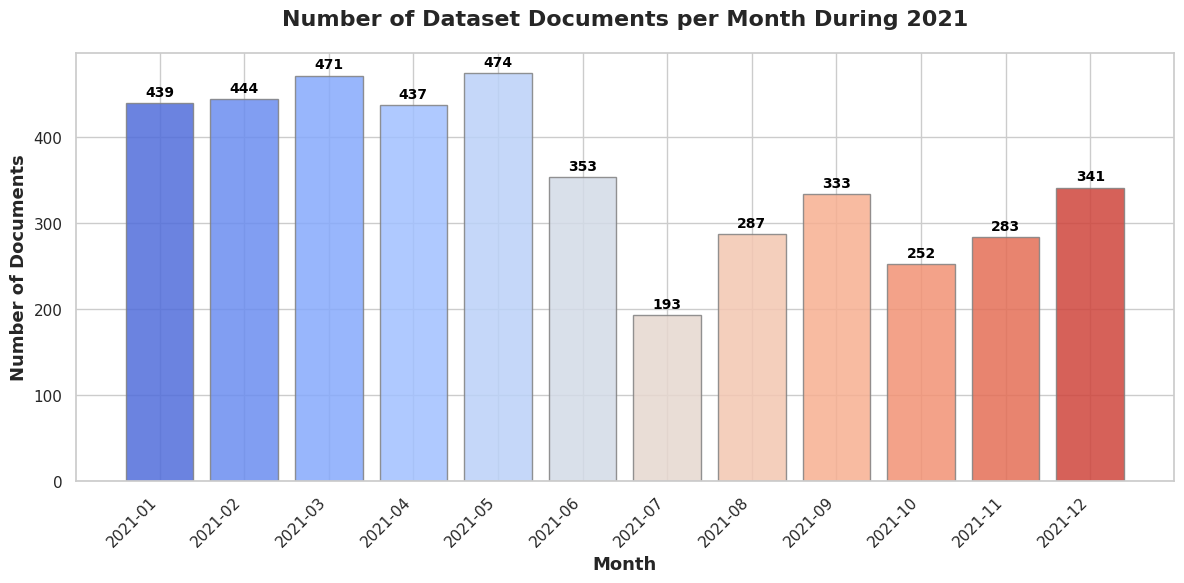

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# retain df within 2021
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= '2021-01-01']
df = df[df['date'] < '2021-12-31']

# Copy and preprocess the dataframe
df_copy = df.copy()
df_copy['date'] = pd.to_datetime(df_copy['date'])
df_copy['date'] = df_copy['date'].dt.to_period('M')
articles_per_month = df_copy['date'].value_counts().sort_index()

# Set the plot style
sns.set(style='whitegrid')  # Use seaborn's whitegrid style

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
colors = sns.color_palette("coolwarm", len(articles_per_month))

# Plot the bar chart with customized settings
bars = ax.bar(articles_per_month.index.astype(str), articles_per_month.values, color=colors, edgecolor='grey', alpha=0.85)

# Add labels above each bar with custom font and color
for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate
        yval + 5,  # Y-coordinate with padding
        int(yval),  # Text to display
        ha='center', va='bottom',  # Center align horizontally, bottom align vertically
        fontsize=10, color='black', fontweight='bold'  # Font properties
    )

# Customize the axes and title
ax.set_title('Number of Dataset Documents per Month During 2021', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Documents', fontsize=13, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

# Cleanup
del df_copy

## Modeling: Fitting a BERTopic model

Let's fit a BERTopic model on the Flashback posts. In order to do this we need to ensure the [`bertopic`](https://maartengr.github.io/BERTopic/index.html) python package is installed in our current Colab notebook environment. We can check which python packages are pre-installed by issuing the command `!pip list`. Since `bertopic` is not included in our programming environment, we install it ourselves using the install command listed on [BERTopic's website](https://maartengr.github.io/BERTopic/index.html).

In [ ]:
!pip install bertopic==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00


<ipython-input-10-e4eafd7d34d2>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


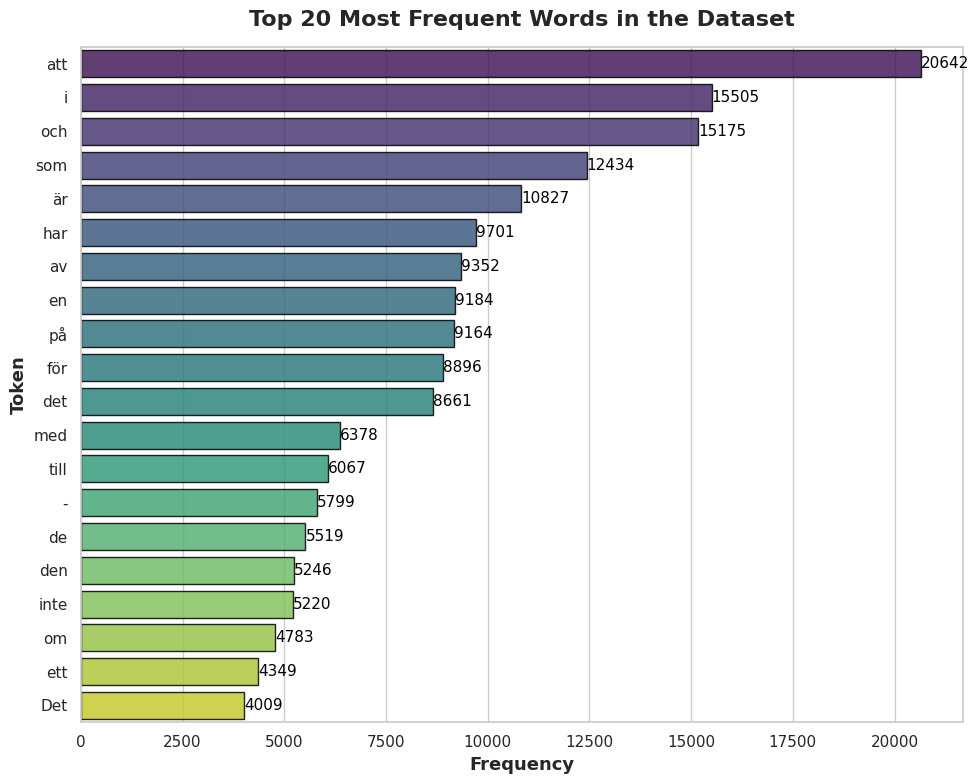

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing a 'text' column
# Explode the words and get the frequency counts
word_counts = df['text'].str.split().explode().value_counts().reset_index()
word_counts.columns = ['Word', 'Frequency']

# Display the top N words, let's say top 20
top_n = 20
word_counts_top_n = word_counts.head(top_n)

# Set up the plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Create a color palette
colors = sns.color_palette("viridis", len(word_counts_top_n))

# Plot the table using seaborn's barplot for visual enhancement
ax = sns.barplot(
    data=word_counts_top_n,
    x='Frequency',
    y='Word',
    palette=colors,
    edgecolor='black',
    alpha=0.85
)

# Add value labels to the bars
for i, (frequency, word) in enumerate(zip(word_counts_top_n['Frequency'], word_counts_top_n['Word'])):
    ax.text(
        frequency + 0.5,  # X-coordinate with a small offset for readability
        i,  # Y-coordinate (vertical position)
        int(frequency),  # The frequency value
        va='center', ha='left',  # Center aligned vertically and left aligned horizontally
        fontsize=11, color='black'
    )

# Customize the plot for readability
ax.set_title(f'Top {top_n} Most Frequent Words in the Dataset', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Frequency', fontsize=13, fontweight='bold')
ax.set_ylabel('Token', fontsize=13, fontweight='bold')

# Adjust layout for neatness
plt.tight_layout()
plt.show()

### Read the list of the Swedish (and some English) stop words

We read the list of stopwords from the file `extended_stopwords.txt` which we downloaded earlier. These will be used to clean up the topic representations and filter out what in this context amounts to mostly non-informative parts of speech. Whereas the choice of stopwords has an effect on the resulting topics in traditional topic modeling, for BERTopic it is actually a ***post-processing*** step that is done after the clustering of topics has already been performed. Thus, in BERTopic, stopwords have basically ***no effect*** on the topics that result from fitting the model. Here, stop words are *only* used to clean up the list of representative words for each topic, and get rid of words we consider to be non-informative.

In [ ]:
# In general, BERTopic will also work well without specifying stop words.
with open("extended_stopwords.txt", 'r') as f:
    stop = f.read().splitlines()
# Obs! the words 'vaccin*' are added as stopWords since these were extremely frequent
import pandas as pd
print(pd.read_csv('extended_stopwords.txt',nrows=5, header=None))

         0
0        a
1    about
2    above
3  absolut
4   across


### Parameters (showcase some of the functionality of BERTopic) before we **Fit** the model

Once the data is organized, it's  time to fit our model. Fitting a BERTopic model is quite straightforward. All we really need to do code wise is:

  1. A list of documents.
  2. Load a relevant sentence transformer model to extract embeddings.
  3. - Initialize BERTopic with the settings we want to use.
     - (Optional) Use Maximal Marginal Relevance as a further post processing step to reduce redundant words in our topic representations (e.g. when both "patient" and "patients" appear a lot in documents, we keep only one as a representative word).
  4. Issue the command to fit the model.  

There are ways to tweak the different components of the model in a more explicit manner. One example is using a different clustering algorithm or [providing different parameters for the clustering algorithm](https://maartengr.github.io/BERTopic/getting_started/clustering/clustering.html). In most cases, however, the default settings will work very well. If you are interested in seeing the different steps of the model laid out explicitly, there is a good explanation to be found on the [BERTopic website](https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview) that explains the algorithm in greater detail.

Below, we set `calculate_probabilities` to `True`, specifying that the BERTopic model should calculate and return the probabilities for any given document belonging to all the different possible topics. This is a setting which increases the computational cost and makes training a model both take longer and consume more memory, but including it will allow us to create some of the visualizations you will see later. If you are more interested in training a model quickly, it's better to set `calculate_probabilities` to `False`.

We'll be using KBLab's own Swedish sentence-transformer ["KBLab/sentence-bert-swedish-cased"](https://huggingface.co/KBLab/sentence-bert-swedish-cased) to create numerical vector representations ("embeddings") of our sentences/paragraphs. You can read more about how this model was trained in a [blog post](https://kb-labb.github.io/posts/2021-08-23-a-swedish-sentence-transformer/) on KBLab's blog.

In [ ]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer # This line is added to import the SentenceTransformer class.
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from bertopic import BERTopic

documents = df["text"].tolist() # Documents as a list

# Step-1: Extract embeddings
# Load KBLab's Swedish sentence transformer model
sentence_model = SentenceTransformer("KBLab/sentence-bert-swedish-cased", device="cpu")

# Step-2: Dimensionality reduction
umap_model = UMAP(n_neighbors=10, n_components=5,
                  min_dist=0.1, metric='cosine', random_state=1337)

# Step-3: Cluster documents
from hdbscan import HDBSCAN
#hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=5, metric='euclidean')

# Step-4: Vectorizer model
from sklearn.feature_extraction.text import CountVectorizer
#vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words=(stop), max_features=5000)   #min_df=0.01), max_df=30)

# Custom token pattern to include underscores and hyphens within words
# Custom token pattern to include underscores and hyphens only if they are within the word
token_pattern = r"(?u)\b\w+(?:[-_]\w+)+\b"

# Adjust the token pattern to exclude underscores
vectorizer_model = CountVectorizer(
    ngram_range=(1, 1),
    stop_words=stop,
    max_features=5000,
    token_pattern=r"(?u)\b\w\w+\b"
)

# Step-5: Topic representation
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step-6: Fine tune topic representation
from bertopic.representation import MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.4, top_n_words=20)

# Initialize BERTopic with the settings we want
topic_model = BERTopic(embedding_model=sentence_model,
                       vectorizer_model=vectorizer_model,
                       umap_model=umap_model,
                       representation_model=representation_model,
                       #hdbscan_model=hdbscan_model,
                       calculate_probabilities=True,
                       nr_topics=18,
                       ctfidf_model=ctfidf_model,
                       min_topic_size=10,
                       #top_n_words=topic_num_words,   # Default is 10.
                       top_n_words=20,
                       verbose=True)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/710 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/399k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### **Fiting** the model on the collection of posts
To create a model using BERTopic, you need to load the posts as a list and then pass it to the fit_transform method. This method will do the following:
* Fit the model on the post collection
* Generate topics
* Return the posts with the topics

The part takes most of the time, that is why there are 2 variants of the same dataset to explore ('all' and a '2500')

In [ ]:
import time
# store starting time
begin = time.time()

topics, probs = topic_model.fit_transform(documents)

# store end time
end = time.time()
# total time taken
print(f"\n\tTotal runtime of the program was {end - begin}")

2024-11-20 07:06:13,134 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/135 [00:00<?, ?it/s]

2024-11-20 08:12:44,004 - BERTopic - Embedding - Completed ✓
2024-11-20 08:12:44,010 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-20 08:13:22,381 - BERTopic - Dimensionality - Completed ✓
2024-11-20 08:13:22,384 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-20 08:13:25,445 - BERTopic - Cluster - Completed ✓
2024-11-20 08:13:25,448 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-20 08:15:05,707 - BERTopic - Representation - Completed ✓
2024-11-20 08:15:05,710 - BERTopic - Topic reduction - Reducing number of topics
2024-11-20 08:15:26,288 - BERTopic - Topic reduction - Reduced number of topics from 86 to 18



	Total runtime of the program was 4153.498167514801


In [ ]:
# get the info of all the topics generated
#topic_model.get_topic_info()
#topic_model.get_topic_info()[1:11]

#(similar to the previous) The default model returned XXX topics. We can look at the top XX topics:
#topic_model.get_topic_info().head(10).set_index('Topic')[['Count', 'Name', 'Representation']]

#OR better:
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare',
                           'Name', 'Representation'] + extra_cols]

get_topic_stats(topic_model)

,Topic,Count,Share,CumulativeShare,Name,Representation
1,0,2022,46.946831,46.946831,0_vaccin_varianten_folkhälsomyndigheten_smitts...,"[vaccin, varianten, folkhälsomyndigheten, smit..."
0,-1,1483,34.432319,81.379150,-1_äldre_pandemin_covid_19_vaccin,"[äldre, pandemin, covid_19, vaccin, covid, reg..."
2,1,250,5.804504,87.183655,1_patienter_postcovid_långtidscovid_krislägesa...,"[patienter, postcovid, långtidscovid, krisläge..."
3,2,129,2.995124,90.178779,2_läkemedlet_molnupiravir_bamlanivimab_behandl...,"[läkemedlet, molnupiravir, bamlanivimab, behan..."
4,3,116,2.693290,92.872069,3_demonstranter_demonstrationen_demonstratione...,"[demonstranter, demonstrationen, demonstration..."
5,4,53,1.230555,94.102624,4_21_plan_flödet_radion,"[21, plan, flödet, radion, marginaler, vinst, ..."
6,5,45,1.044811,95.147434,5_läkaren_polisen_bedragare_intyg,"[läkaren, polisen, bedragare, intyg, borås, ut..."
7,6,33,0.766195,95.913629,6_facebook_desinformation_youtube_videor,"[facebook, desinformation, youtube, videor, or..."
8,7,25,0.580450,96.494079,7_psykisk_ångest_ohälsa_psykiska,"[psykisk, ångest, ohälsa, psykiska, självmord,..."
9,8,23,0.534014,97.028094,8_miljarder_pengar_2022_magdalena_andersson,"[miljarder, pengar, 2022, magdalena_andersson,..."


In [ ]:
#timestamps = df["date"].dt.year.tolist() # Extract the year each eg post was published
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
timestamps = df["date"].dt.month.tolist() # Extract the month each article
#the previous moved at the begining!

topics_over_time = topic_model.topics_over_time(documents, timestamps)

12it [02:51, 14.25s/it]


In [ ]:
#topic_model.visualize_topics_over_time(topics_over_time, topics=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
topic_model.visualize_topics_over_time(topics_over_time, topics=list(range(1, 16)))

In [ ]:
#new
topics_over_time = topic_model.topics_over_time(documents, timestamps, nr_bins=10, evolution_tuning=True)
topic_model.visualize_topics_over_time(topics_over_time, width=800)

10it [02:40, 16.04s/it]


### Overview of topics

Let's investigate how many topics BERTopic grouped our documents into by using `topic_model.get_topic_info()`. Here, the column **Topic** enumerates the different topics. **Count** shows how many topics were assigned to a given topic. **Name** displays the most representative words for documents contained within the topic.

Topic `-1` is special, indicating those documents that could not be assigned in to a topic. We can increase the number of documents assigned to documents by changing parameters before fitting, or by lowering the inclusion threshold, but this may come at the cost of making the topics "noisier" (less specific to a given subject).

In [ ]:
topic_labels = topic_model.generate_topic_labels(nr_words=15,
                                                 topic_prefix=True,
                                                 word_length=20,
                                                 separator=", ")
topic_labels

['-1, äldre, pandemin, covid_19, vaccin, covid, regioner, vaccinera, patienter, folkhälsomyndigheten, restriktioner, regeringen, vaccinationer, befolkningen, eu, stockholm',
 '0, vaccin, varianten, folkhälsomyndigheten, smittspridningen, ema, eu, brittiska, vaccinerade, covid_19, smittade, covid, indien, coronavirus, vaccinet, blodproppar',
 '1, patienter, postcovid, långtidscovid, krislägesavtalet, fetma, läkare, symtom, iva, socialstyrelsen, diagnosen, vården, rehabilitering, regioner, primärvården, covidpatienter',
 '2, läkemedlet, molnupiravir, bamlanivimab, behandlingen, remdesivir, antikroppen, celler, antivirala, monoklonala_antikrop, patienter, nano, placebo, tocilizumab, ivermectin, antikropp',
 '3, demonstranter, demonstrationen, demonstrationer, coronarestriktioner, poliser, protester, pandemilagen, polis, protestera, berlin, sjöström, stockholm, samlas, greps, restriktioner',
 '4, 21, plan, flödet, radion, marginaler, vinst, närvarande, svarar, balans, styrande, samordna, k

In [ ]:
# Loop through the topics and get the top n words based on their c-TF-IDF scores:
def getTopTopics(min_score):
  topic_info = topic_model.get_topic_info()
  for index, row in topic_info.iterrows():  # Iterate using the dataframe index
    topic_num = row['Topic']  # Get the topic number from the dataframe

    if topic_num != -1:  # Check if the topic is not -1 (outlier topic)
      print(f"\nTopic: {topic_num + 1}\n")  # Adjust topic number for display

      # Get topic representation
      topic_representation = topic_model.get_topic(topic_num)

      if topic_representation:  # Check if topic representation is valid
          for t in topic_representation:
              if t[1] >= min_score:
                  print(f"\t{t[0]:<12} | \t{t[1]}")
      else:
          print(f"Could not retrieve information for topic {topic_num + 1}")

getTopTopics(0.03)


Topic: 1

	vaccin       | 	0.21328948385225835
	varianten    | 	0.2097590207191555
	folkhälsomyndigheten | 	0.201756626396277
	smittspridningen | 	0.18809087209324946
	ema          | 	0.18525605288052627
	eu           | 	0.18499275645039384
	brittiska    | 	0.17911779537063496
	vaccinerade  | 	0.17882965008183224
	covid_19     | 	0.178635041829222
	smittade     | 	0.17844079358403875
	covid        | 	0.17740405492097577
	indien       | 	0.17682724695409882
	coronavirus  | 	0.17316070904978523
	vaccinet     | 	0.17247967151153215
	blodproppar  | 	0.1700655551754165
	regioner     | 	0.16957254939074848
	vaccination  | 	0.1681360456498835
	vaccinera    | 	0.16561073639220267
	restriktioner | 	0.16342093121923845
	mutationer   | 	0.1614037951255023

Topic: 2

	patienter    | 	0.39872104400838404
	postcovid    | 	0.3970789444109318
	långtidscovid | 	0.3639745549785125
	krislägesavtalet | 	0.35446686488497986
	fetma        | 	0.32605554131052605
	läkare       | 	0.3233321366454736
	symtom  

### Dynamic topic modeling (topics over time)

Traditional topic models were eventually extended and developed to answer more complex research questions. One such branch of topic modeling was the [Dynamic Topic Model (DTM)](https://en.wikipedia.org/wiki/Dynamic_topic_model). DTM's introduced *time* as a variable, in order to analyze the evolution of topics over time.

In BERTopic, we can emulate DTM provided that we have a time variable, using the `.topics_over_time()` method. We need to provide both the original documents, and their corresponding timestamps to this method.
We then visualize the topics using the `.visualize_topics_over_time()` method.

**Tip**: *You can click on topics under the legend "Global Topic Representations" to the right to de-select or select topics to be drawn if the diagram looks too cluttered.*

### Term Score Decline

To get this diagram, we run the `topic_model.visualize_term_rank()`. The annotation(s) in red are manually selected topic to visualize.

In [ ]:
#Visualize Term Score Decline
topic_model.visualize_term_rank(log_scale=True,  width=900, title='<b>Word Scores decline per Topic: Dataset COVID-19 2021</b>', topics = [2,4,10])

### Group topics according to categories/classes

In the dataset, we have do not have different subdivisions of for example authors or polarity, into which we could group the documents from different topics. This could allow us to explore how different post frame the discussion around a topic, in terms of the terms and words that the  uses when drafting postsrelating to that particular topic. This can be done using the `.topic_per_class` method, supplying the original documents along with corresponding classes the documents belong to.

**Tip**: *You can click on topics under the legend "Global Topic Representations) to the right to select or de-select topics to be included in the bar diagram. Hover over the bars to see the words the different authors were more likely to use for a given topic.*

In [ ]:
classes = df["genre"].tolist()
topics_per_class = topic_model.topics_per_class(documents, classes=classes)
topic_model.visualize_topics_per_class(topics_per_class, topics=list([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]),width=900, title='<b>Topics per Genre</b>')

8it [01:51, 13.92s/it]


In [ ]:
topic_distr, _ = topic_model.approximate_distribution(documents, min_similarity=0.0)
# To visualize the topic distributions in a document
topic_model.visualize_distribution(topic_distr[1], width=900, title='<b>Topic Probability Distribution:  COVID-19 dataset</b>')
# To visualize the probabilities of topic assignment
#topic_model.visualize_distribution(probs[1])

100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


### Term Visualization
We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other. The `ngram_range`parameter allows us to decide how many tokens each entity is in a topic representation.
For example, we have words like game and team with a length of 1 in a topic but it would also make sense to have words like hockey league with a length of 2. To allow for these words to be generated, we can set the ngram_range parameter


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words=(stop))
topic_model.update_topics(documents, vectorizer_model=vectorizer_model)

topic_model.visualize_barchart(top_n_topics = 18, n_words = 10, width=350, title='<b>Topics\' Word Scores: COVID-19 dataset</b>')
#topic_model.visualize_barchart(topics=[5,7], n_words=10, width=350 ,  title='<b>Topics\' Word Scores - Swedish COVID-19 data</b>')

### Distribution of representative words of any topic and representative documents
Using the `topic_model.get_topic()` model function. It allows us to view the distribution of words within topics.
Using the `topic_model.get_representative_docs()` let us explore representative documents for a given topic.

In [ ]:
topic_model.get_topic(8, full=True)

{'Main': [('miljarder', 0.19659795644160877),
  ('kronor', 0.11980443929363739),
  ('regeringen', 0.07306556967287636),
  ('pengar', 0.06434114938089015),
  ('eu', 0.05470625476107536),
  ('2022', 0.04619359063592249),
  ('avsätts', 0.03893111761667261),
  ('stödet', 0.038641332229899204),
  ('avsätter', 0.03764212490117754),
  ('magdalena_andersson', 0.03537651450931837)]}

In [ ]:
# View representative documents for a topic, eg. 8
topic_model.get_representative_docs(8)

['Regeringen satsar miljarder kronor extra på sjukvården under i budgetpropositionen som presenterades på måndagen. Bland_annat ska miljarder vigas till köer i pandemins kölvatten och 1,5 miljarder till en förlängd satsning i förlossningsvården. - Vi kommer att avsätta miljarder kronor för att beta av de köer som uppstått i sjukvården under corona. Tillsammans med tidigare aviserad politik avsätter vi miljarder kronor nästa år för att beta av coronaköer i sjukvården, sa finansminister Magdalena_Andersson (S) under presentationen av regeringens proposition på måndagen. Precis hur de nya miljarder ska användas är inte bestämt; bara att pengar ska gå till riktade insatser under 2022. Regioner och kommuner får också miljoner kronor för att ersätta merkostnader till_följd_av covid-19. En nygammal satsning på personalen görs med miljarder kronor årligen under och 2023. - Vi vet att personalen i hälso- och sjukvården har gjort fantastiska insatser under den här pandemin. Och för att vi både s

### Search for topics with a search query

When we have a large amount of topics, it may be practical to search whether a topic exists. We can do this by using `topic_model.find_topics()`, and entering any word or text we are interested in as an argument to the method.

In [ ]:
similar_topics, similarity = topic_model.find_topics("demonstrationer", top_n=5)
similar_topics

[3, 4, 5, 15, 16]

## Visualization Explorations
We can visualize the topics in to a two-dimensional space using the `topic_model.visualize_topics()` function. This allows us to see which topics are seemingly more related to each other, and get more insights into the topic's quality. Topics found closer together tend to be related.

In [ ]:
topic_model.visualize_topics(width=900, title='<b>Intertopic Distance Map: Flashback COVID-19 vaccination dataset</b>')

### Hierarchical clustering visualization

Another way of visualizing which topics are related to each other is to create a hierarchical clustering diagram.

In [ ]:
topic_model.visualize_hierarchy(width=900, title='<b>Hierarchical Clustering: Flashback COVID-19 vaccination dataset</b>')

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(documents)
topic_model.visualize_hierarchy(width=900, hierarchical_topics=hierarchical_topics,  title='<b>Hierarchical Clustering: COVID-19 dataset</b>')

100%|██████████| 16/16 [00:00<00:00, 60.91it/s]


### Heatmaps and Similarity Matrix
Visualize a heatmap of the topic's similarity matrix. Based on the cosine similarity matrix between topic embeddings, a heatmap is created showing the similarity between topics.

In [ ]:
topic_model.visualize_heatmap(top_n_topics=16, width=1000, title='<b>Similarity Matrix: Flashback COVID-19 vaccination dataset</b>',custom_labels=True)

In [ ]:
 #Create n clusters and order the similarity matrix by those clusters.
topic_model.visualize_heatmap(n_clusters=16, width=1000,title='<b>Similarity Matrix: Flashback COVID-19 vaccination dataset</b>', custom_labels=True)

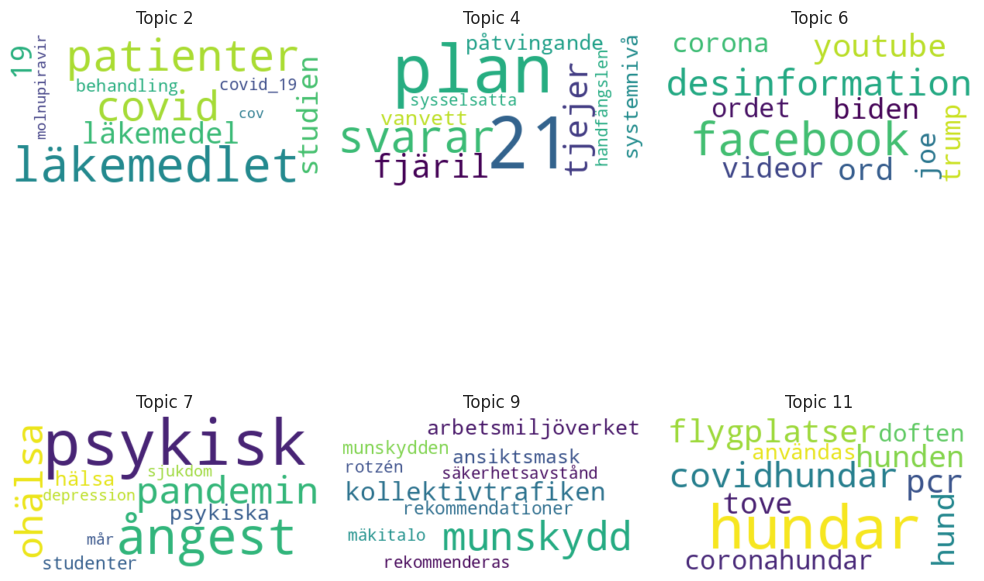

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topics):
    # Calculate the number of rows and columns for the grid layout
    num_topics = len(topics)
    num_cols = 3  # You can adjust the number of columns as needed
    num_rows = (num_topics + num_cols - 1) // num_cols # Calculate rows based on topics and columns

    # Create the grid layout with the calculated dimensions
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))  # Adjust figsize as needed
    axs = axs.flatten()  # Flatten to easily iterate over subplots

    for i, topic in enumerate(topics):
        text = {word: value for word, value in model.get_topic(topic)}
        wc = WordCloud(background_color="white", max_words=1000)
        wc.generate_from_frequencies(text)

        # Plot each word cloud in its respective subplot
        axs[i].imshow(wc, interpolation="bilinear")
        axs[i].axis("off")
        axs[i].set_title(f"Topic {topic}")  # Optional: Title each subplot

    # Hide any empty subplots if the number of topics is not a multiple of the grid size
    for j in range(num_topics, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Show wordclouds for multiple topics
create_wordcloud(topic_model, topics=[2, 4, 6, 7, 9, 11])

## Acknowledgements

This notebook was highly inspired by a workshop created by KBLab, a data lab at the National Library of Sweden. The following members from KBLab participated in creating and presenting different segments of the workshop (reused in this notebook):

**Faton Rekathati** (Notebook, code, visualizations)  
**Chris Haffenden**  (Interpretation of results, feedback on notebook)    
**Love Börjeson**  (Introduction to topic modeling)  

Adaptations (Jan-Feb 2024) by:
**Dimitrios Kokkinakis**  (New data; stopwords; some new visualiztions)